# Exploratory Spatial Data Analysis of Disaster-Tweets

With this notebook, you can analyse tweets that were posted in the same area and on the same day as the Napa earthquake in 2014 (see https://en.wikipedia.org/wiki/2014_South_Napa_earthquake for details).  

### Assignment

Create a new markdown cell to answer the following questions:

* How many tweets are in the dataset?
* What words are the most frequent words in the wordcloud (related to the size of the words)?
* Perform  topic modelling with and without preprocessing. What could you observe?
* Which topics could you identify in the datasets? Can you label some of the topics?
* What is the min and max date of the dataset?
* How does the time-series of the disaster-related topic and the overall dataset differ?
* How does the heatmap of the disaster-related topic and the overall dataset differ?

When you are answered the questions, download your notebook as html-file and check if it worked.
File -> Download as -> HTML

Hint: You do not have to program somehting by yourself, but you have to understand the code (change some variables) and look for the answers of the questions.


## Load dataset and libraries

In [6]:
%matplotlib inline

In [7]:
from preprocessing import *
import gensim
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium
import pyLDAvis.gensim
import statistics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [8]:
df = pd.read_csv('../tweets/napa_tweets.csv', sep=',', error_bad_lines=False, index_col=False, warn_bad_lines=False)
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.head(5)

id              time                                  tweet_text  \
0   0  24.08.2014 23:07                             SMITE vs LOL ??   
1   1  24.08.2014 23:12  Random people complimenting you is so nice   
2   2  24.08.2014 23:37                  Calum is being an annoying   
3   3  24.08.2014 23:38                                      Plan B   
4   4  24.08.2014 23:42                              Laaawwwwllllll   

    latitude   longitude  
0  37.600700 -122.014820  
1  38.417359 -122.709612  
2  37.353794 -121.863898  
3  37.957866 -122.032392  
4  38.338400 -122.685784

In [9]:
df.shape

(90907, 5)

## Natural language processing

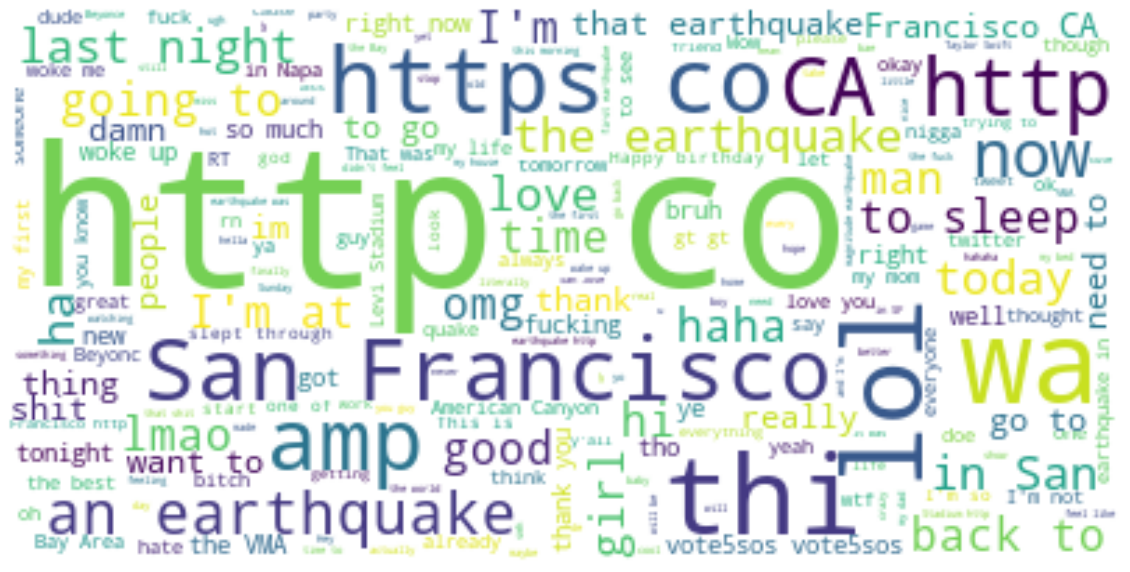

In [10]:
wordcloud = WordCloud(background_color='white').generate(' '.join(df['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Download nltk Ressources.

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\b1022699\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\b1022699\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Transform tweets text into usable format

In [12]:
#tweets' text as list
tweets_text = df['tweet_text'].tolist()
#lowercase
tweets_text=[tweet.lower() for tweet in tweets_text]

#remove URLs
remove_url_regex = r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'
tweets_text = filter_tweets_before_tokenization(tweets_text, remove_url_regex)

#tokenization
tweets_text=[nltk.word_tokenize(tweet) for tweet in tweets_text]

### Text preprocessing

Test multiple preprocessing procedures and observe their impact on the analysis results

In [13]:
#remove special characters
remove_sc_regex = r'[^A-Za-z ]+'
tweets_text = filter_tweets_after_tokenization(tweets_text, remove_sc_regex)

# remove short words
remove_short_words_regex = r'\W*\b\w{1,3}\b'
tweets_text = filter_tweets_after_tokenization(tweets_text, remove_short_words_regex)

# Remove all user names in the tweet text
user_names_regex = r"@\S+"
tweets_text = filter_tweets_after_tokenization(tweets_text,user_names_regex)

#increase keyword frequency by aggregating similar keywords
# check the order if preprocessing routine! e.g. stemming would effect the performance of synonym handling
#disaster = 'hurrican'
#disaster_terms = ['hurricane', 'hurricaneharvey', 'hurricane_harvey', 'flood', 'storm']
#tweets_text = synonym_handling(tweets_text, disaster, disaster_terms)

#Remove unique words that appear only once in the dataset
frequency = getFrequency(tweets_text)
min_frequency_words = 2
tweets_text = [[token for token in tweet if frequency[token] > min_frequency_words] for tweet in tweets_text]

# Remove stop words
# You need to download the stopwords
from nltk.corpus import PlaintextCorpusReader
stoplist = set(stopwords.words('english'))
tweets_text = [[word for word in document if word not in stoplist] for document in tweets_text]

#Stemming
stemmer = PorterStemmer()
#stemmer = SnowballStemmer("english")
tweets_text = [[stemmer.stem(word) for word in sub_list] for sub_list in tweets_text]

#remove empty strings
tweets_text = [[word for word in document if word] for document in tweets_text]

tweets_text[:10]

[[],
 ['random', 'peopl', 'nice'],
 ['calum', 'annoy'],
 ['plan'],
 [],
 [],
 ['earthquak'],
 [],
 ['time'],
 []]

Create corpus and dictionary for LDA

In [14]:
dict = gensim.corpora.Dictionary(tweets_text)
corpus = [dict.doc2bow(text) for text in tweets_text]

Train Model

In [15]:
num_topics= 10
alpha = 0.0001
eta= 0.0001
passes = 10
lda = gensim.models.LdaMulticore(corpus, id2word=dict, num_topics= num_topics, alpha = alpha, eta= eta, passes = passes)

Show top words of topics

In [16]:
top_words = 5

#show top words of topics
for t in range(lda.num_topics):
    print('topic {}: '.format(t+1) + ', '.join([v[0] for v in lda.show_topic(t, top_words)]))

#show top words of topics with probabilities  
#for t in range(lda.num_topics):
#   print('topic {}: '.format(t+1) + ', '.join([v[0] + " (" + str(v[1]) + ")" for v in lda.show_topic(t, top_words)]))


topic 1: earthquak, felt, thought, woke, sleep
topic 2: make, sleep, think, cute, look
topic 3: fuck, shit, nigga, know, even
topic 4: like, work, look, time, shit
topic 5: earthquak, napa, california, quak, first
topic 6: school, tomorrow, miss, thank, happi
topic 7: night, feel, last, realli, good
topic 8: beyonc, francisco, look, bruh, yeah
topic 9: love, vma, watch, game, show
topic 10: need, come, want, time, back


### Visualise topics and check relation between them
If the window is not big enough, you can enlarge it with Cell -> Current Outputs -> Toggle Scrolling 

In [30]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dict, sort_topics=False)
print(vis.topic_order)
pyLDAvis.display(vis)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Identify disaster-related topic and classify tweets accordingly

In [31]:
document_topic_list = list(lda.get_document_topics(corpus))
classified_tweets =[max(document, key=lambda x: x[1]) for document in document_topic_list]
topics = [top_prob[0]+1 for top_prob in classified_tweets]
probabilites = [top_prob[1] for top_prob in classified_tweets]
df['topics'] = topics
df['probabilities'] = probabilites

Check classified tweets

In [32]:
topic_number = 6
df.loc[df['topics'] == topic_number].head(10)

id                time                                      tweet_text  \
16  16 2014-08-24 08:28:00                                       Waiting..   
29  29 2014-08-24 10:38:00        I was suppose to go shopping tomorrow ??   
34  34 2014-08-24 10:51:00           I am slightly sad I missed it though.   
39  39 2014-08-24 11:06:00                          @itserikatho gotchuuuu   
53  53 2014-08-24 15:05:00                                        Wait HUH   
62  62 2014-08-24 16:31:00                      I'm ready for another one!   
63  63 2014-08-24 16:32:00  i likeee youuu. a loooott ?? soorry, not sorry   
68  68 2014-08-24 17:10:00              Free idea: Yo app for earthquakes.   
74  74 2014-08-24 18:21:00                             My mom is the best.   
84  84 2014-08-24 19:02:00                      Red bull makes me so happy   

     latitude   longitude  topics  probabilities  count  
16  37.715207 -122.445143       6       0.999101      1  
29  38.317200 -122.293194       6       0.999700      1  
34  38.430949 -121.424592       6       0.666472      1  
39  37.780821 -122.449895       6       0.999098      1  
53  37.709565 -121.421924       6       0.999101      1  
62  37.923447 -122.324942       6       0.999550      1  
63  37.316324 -121.908246       6       0.510675      1  
68  37.795673 -122.413791       6       0.666418      1  
74  37.195854 -121.832629       6       0.999101      1  
84  37.739886 -121.437277       6       0.379325      1

## Check time-series

In [33]:
df['time'] = pd.to_datetime(df['time'])

In [34]:
print(min(df['time']))
print(max(df['time']))

2014-08-24 07:00:00
2014-08-25 06:59:00


Text(0, 0.5, '#Tweets')

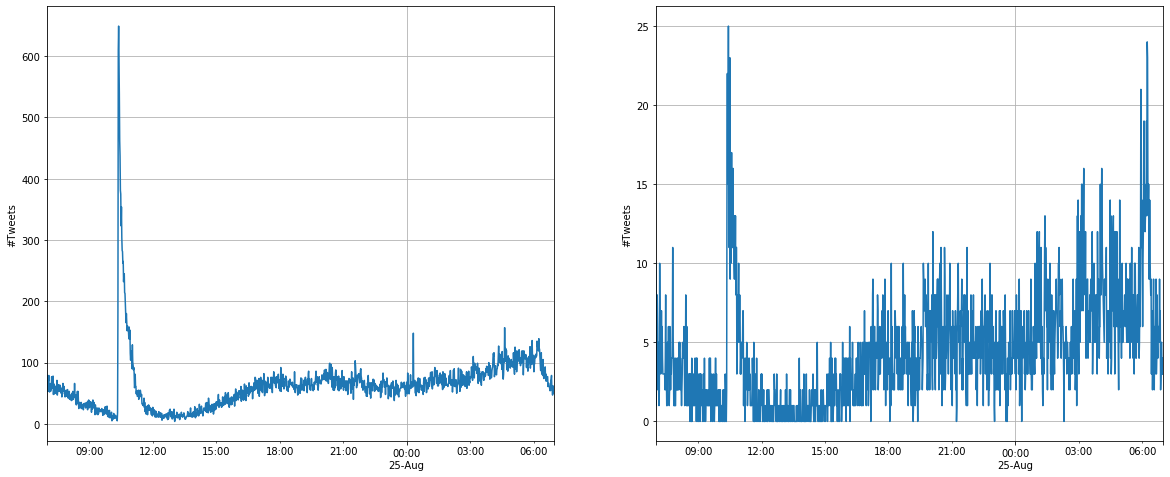

In [35]:
topic_number = 8
figure, axes = plt.subplots(1, 2,figsize=(20,8))

df_sum = df['time'].value_counts().resample('T').sum()
ax = df_sum.plot(label='Number of Tweets',ax=axes[0])
axes[0].grid()
axes[0].set_ylabel("#Tweets")

df_topic = df.loc[df['topics'] == topic_number]
df_sum = df_topic['time'].value_counts().resample('T').sum()
ax = df_sum.plot(label='Number of Tweets',ax=axes[1])
axes[1].grid()
axes[1].set_ylabel("#Tweets")

## Check geospatial distribution

In [36]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [37]:
y = statistics.mean(df['latitude']) 
x = statistics.mean(df['longitude']) 

In [38]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

df['count'] = 1
base_map = generateBaseMap([y,x],8)
HeatMap(data=df[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
display(base_map)

In [39]:
topic_numbers = [4,8]
base_maps = []
for topic_number in topic_numbers:
    df_topic = df.loc[df['topics'] == topic_number]
    base_map = generateBaseMap([y,x],8)
    HeatMap(data=df_topic[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
    base_maps.append(base_map)

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(base_maps[0].get_root().render().replace('"', '&quot;'),500,500,
                   base_maps[1].get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


More information

* [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [Combining machine-learning topic models and spatiotemporal analysis of social media data for disaster footprint and damage assessment](https://www.tandfonline.com/doi/full/10.1080/15230406.2017.1356242)
* [Gensim](https://radimrehurek.com/gensim/)

# Classify Tweet sentiments

Finally, let us use a state-of-the-art artificial intelligence sentiment classification method, called RoBERTa. RoBERTA stands for Robustly Optimized BERT Pretraining Approach and can be used for different natural language processing tasks.

Orignal paper: https://arxiv.org/abs/1907.11692

Code source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment


## Load the model
Run the code below

In [41]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [42]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [43]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [44]:
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

### Preprocessing the data

In [45]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

## Test the model

In [46]:
text = "Good night 😊"
text = preprocess(text)

In [47]:
def get_sentiment(text, printing = True):
    
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    sentiment = 'positive'
    if scores[0] == max(scores):
        sentiment = 'negative'
    if scores[1] == max(scores):
        sentiment = 'neutral'
        
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    if printing == True:
        for i in range(scores.shape[0]):
            l = labels[ranking[i]]
            s = scores[ranking[i]]
            print(f"{i+1}) {l} {np.round(float(s), 4)}")
            
    return sentiment

In [48]:
get_sentiment(text)

1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


'positive'

#### Also try your own text .


In [49]:
text = "Twitter is the best social network! @Twitter"
text = preprocess(text)
get_sentiment(text)

1) positive 0.9889
2) neutral 0.01
3) negative 0.0011


'positive'

In [50]:
text = "The most retweeted tweets are boring!"
text = preprocess(text)
get_sentiment(text)

1) negative 0.6886
2) neutral 0.241
3) positive 0.0705


'negative'

In [51]:
text = "The football game last night was fire!"
text = preprocess(text)
get_sentiment(text)

1) positive 0.9611
2) neutral 0.0361
3) negative 0.0028


'positive'

## Classify the sentiment for a random sample of size 1000

In [52]:
df_sent = df.sample(100)
df_sent['sentiment'] = 'no_sentiment'

In [56]:
import time
#df_sent['sentiment'] =  df_sent.tweet_text.apply(lambda row: get_sentiment(preprocess(row),printing=False))
start = time.time()
counter = 0
for index, row in df_sent.iterrows():
    text = row['tweet_text']
    
    sentiment = get_sentiment(preprocess(text),printing=False)

    df_sent.loc[df_sent.index ==index, 'sentiment'] = sentiment

    print(counter)
    counter +=1
end = time.time()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [57]:
print('Number of positive tweets: ', (len(df_sent[df_sent.sentiment == 'positive'])))
print('Number of negative tweets: ', (len(df_sent[df_sent.sentiment == 'negative'])))

Number of positive tweets:  29
Number of negative tweets:  28


In [58]:
print('It took %d seconds to get the sentiment for %d tweets'%((end-start), len(df_sent)))

It took 3 seconds to get the sentiment for 100 tweets


## Build and compare wordclouds according to the diffferent sentiments 
What do you notice?

In [60]:
from PIL import Image
import random

mask = np.array(Image.open('tweets/twitter_mask.png'))

### Postive

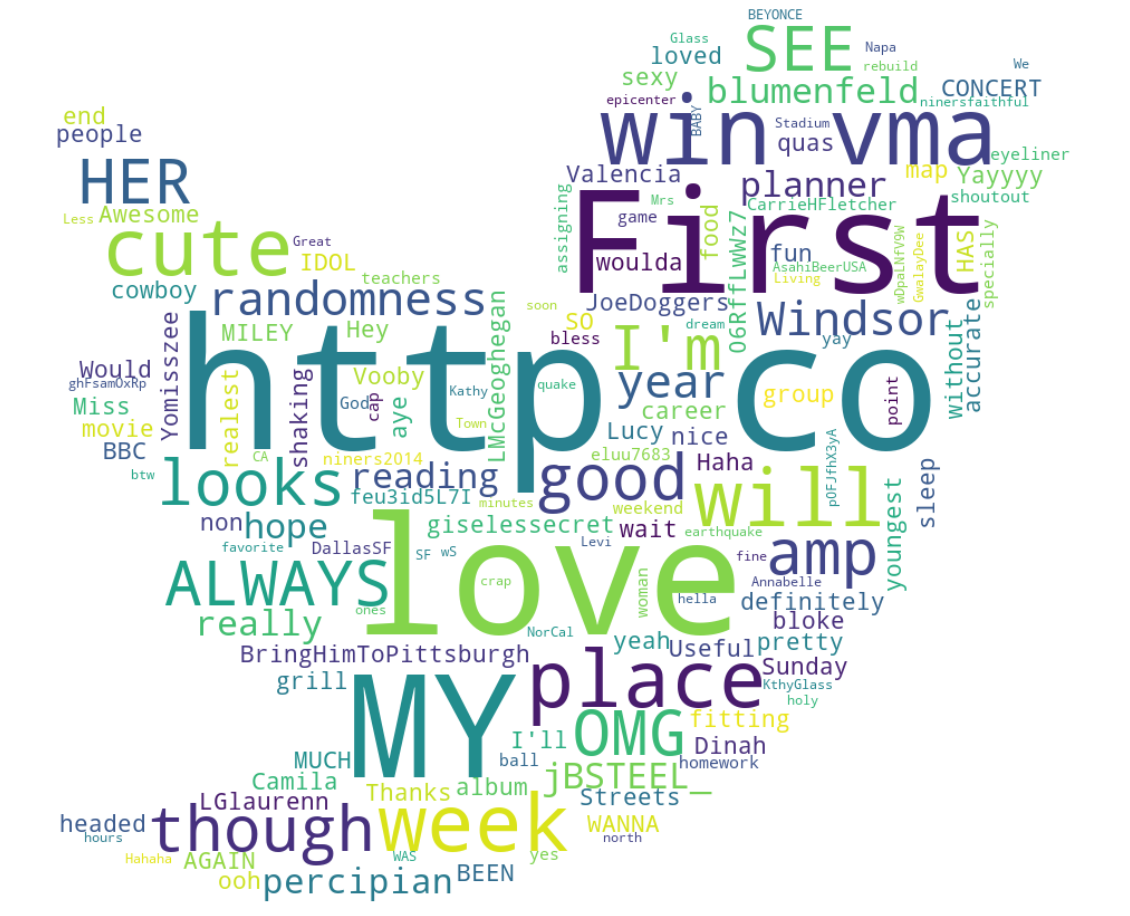

In [61]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_sent[df_sent.sentiment=='positive']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Negative

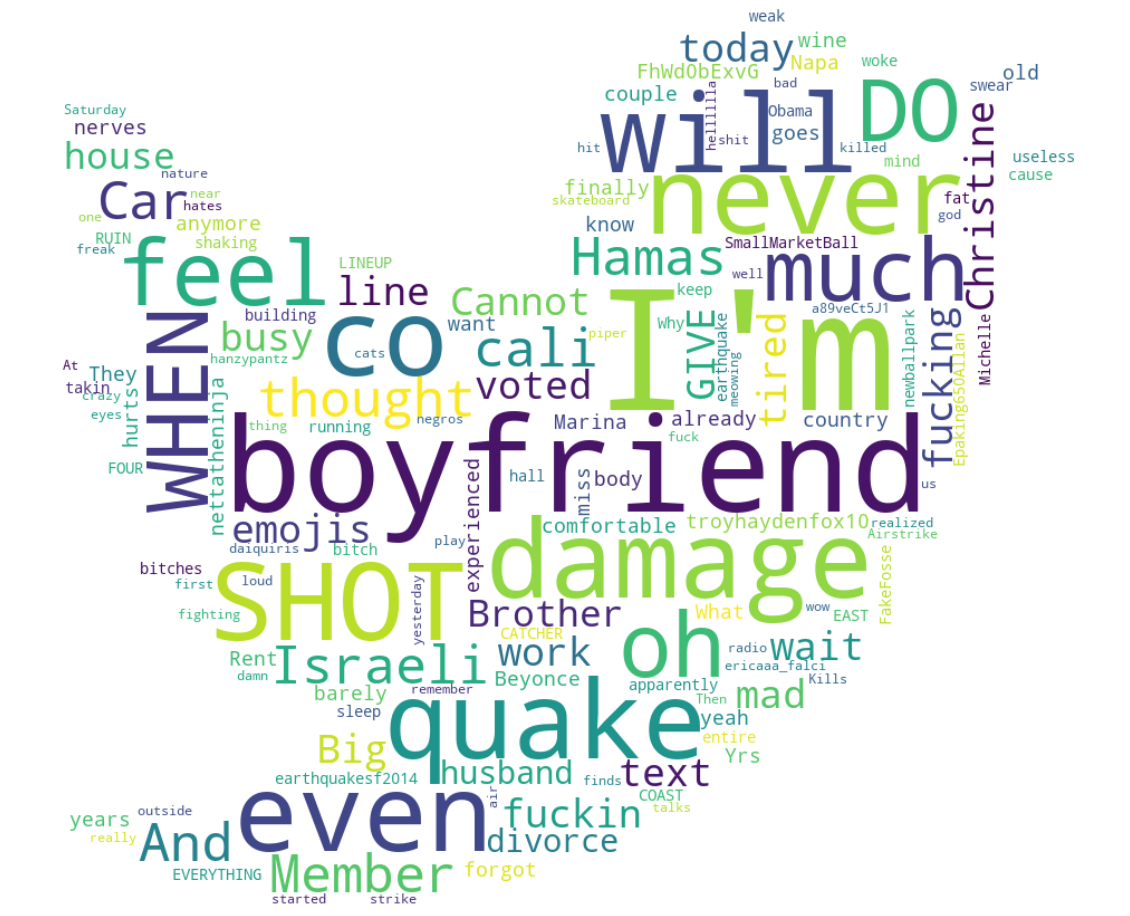

In [62]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_sent[df_sent.sentiment=='negative']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Neutral

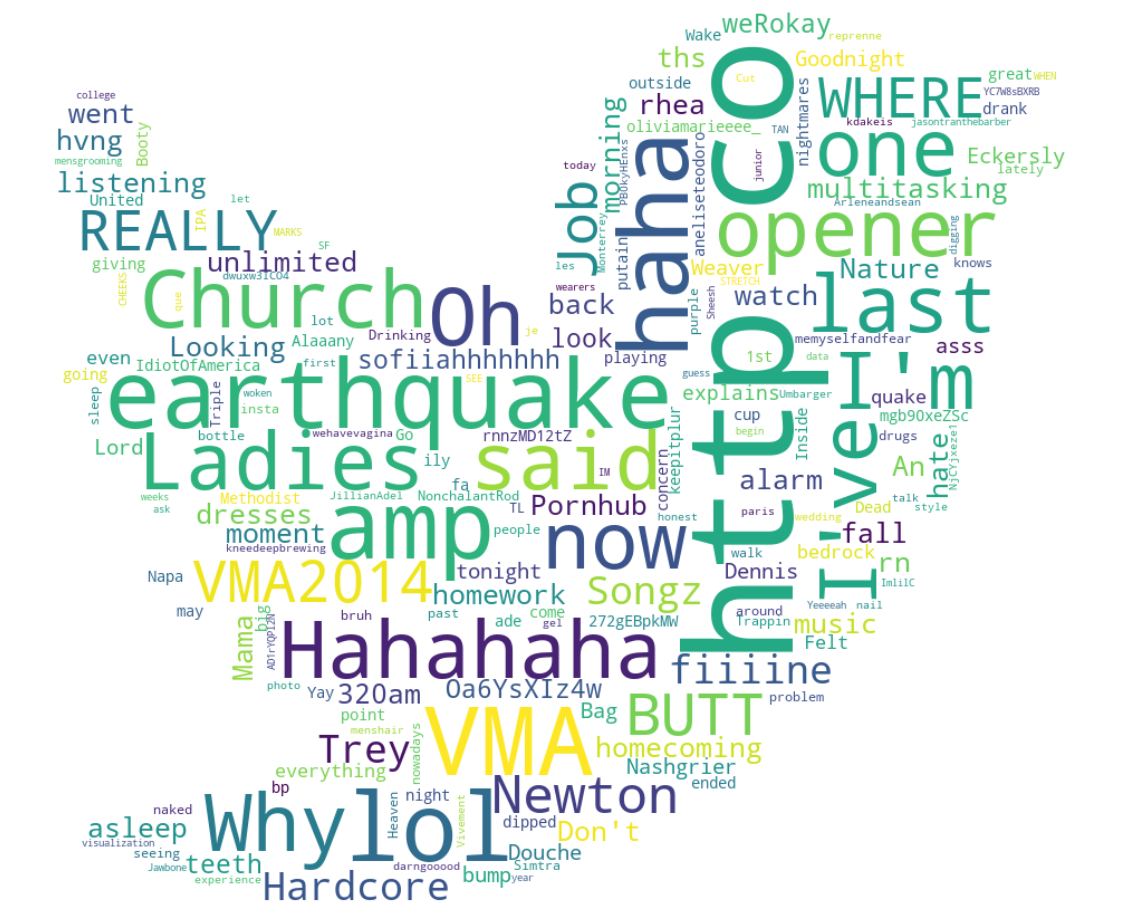

In [63]:
wordcloud = WordCloud(background_color='white',mask=mask).generate(' '.join(df_sent[df_sent.sentiment=='neutral']['tweet_text']))
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Compare sentiment timelines for different topics

Napa earthquake took place at 03:20:44 Pacific Daylight Time which is 10:20:44 in GMT

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
df_earth = pd.read_csv('../tweets/tweets_earth_sent.csv', index_col=0)
df_bey = pd.read_csv('../tweets/tweets_bey_sent.csv', index_col=0)
#df_love = pd.read_csv('tweets_love_sent.csv',index_col=0)

df_earth['time'] = pd.to_datetime(df_earth['time'])
df_bey['time'] = pd.to_datetime(df_bey['time'])
#df_love['time'] = pd.to_datetime(df_love['time'])

In [88]:
df_earth

id                time  \
6          6 2014-08-24 23:48:00   
32        32 2014-08-24 10:44:00   
36        36 2014-08-24 10:58:00   
38        38 2014-08-24 11:05:00   
43        43 2014-08-24 11:27:00   
...      ...                 ...   
90736  90736 2014-08-25 06:56:00   
90743  90743 2014-08-25 06:57:00   
90763  90763 2014-08-25 06:57:00   
90821  90821 2014-08-25 06:58:00   
90868  90868 2014-08-25 06:59:00   

                                              tweet_text   latitude  \
6                                  6.0 earthquake ??????  38.385827   
32                        @vihartvihart Your first time?  37.577838   
36                                        LOL Earthquake  37.715804   
38     That earthquake got me like http://t.co/Tk7MVC...  38.170785   
43     @AliceRadio @cnnbrk Hwy 37 closed for inspecti...  38.157894   
...                                                  ...        ...   
90736  #mansion #winchestermysteryhouse #sunrays @ Wi...  37.318455   
90743                               Franklin // Paramore  38.892928   
90763  I had a soldier in my unit kill himself last y...  37.809680   
90821  That earthquake was not scary at all. (From 2,...  37.760526   
90868  #Retail #Job in #SanFrancisco, CA: Specialty A...  37.774930   

        longitude  topics  probabilities  count sentiment  
6     -121.418772       5       0.999101      1   neutral  
32    -122.352447       5       0.999550      1   neutral  
36    -122.450637       5       0.999101      1   neutral  
38    -122.129890       5       0.500710      1  negative  
43    -122.178519       5       0.713443      1  negative  
...           ...     ...            ...    ...       ...  
90736 -121.951354       5       0.690355      1   neutral  
90743 -121.304896       5       0.999550      1   neutral  
90763 -122.285612       5       0.370572      1  negative  
90821 -122.406268       5       0.787321      1  positive  
90868 -122.419416       5       0.568297      1   neutral  

[9187 rows x 9 columns]

In [89]:
resample_time = 'T'
df_sum_earth_pos = df_earth.loc[df_earth.sentiment=='positive']['time'].value_counts().resample(resample_time).sum()
df_sum_earth_neg = df_earth.loc[df_earth.sentiment=='negative']['time'].value_counts().resample(resample_time).sum()

df_sum_bey_pos = df_bey.loc[df_bey.sentiment=='positive']['time'].value_counts().resample(resample_time).sum()
df_sum_bey_neg = df_bey.loc[df_bey.sentiment=='negative']['time'].value_counts().resample(resample_time).sum()

#df_sum_love_pos = df_love.loc[df_love.sent=='positive']['time'].value_counts().resample(resample_time).sum()
#df_sum_love_neg = df_love.loc[df_love.sent=='negative']['time'].value_counts().resample(resample_time).sum()

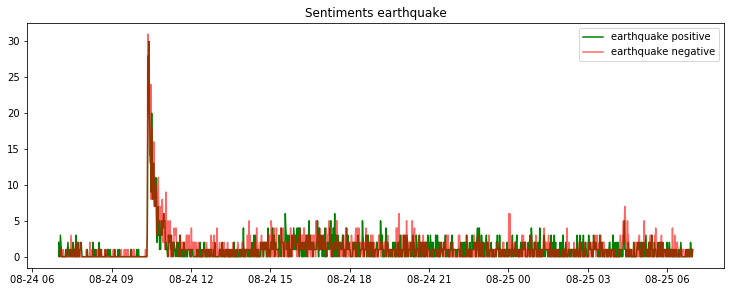

In [90]:
plt.figure(figsize=(12.5,4.5))
plt.plot(df_sum_earth_pos,label = 'earthquake positive',color='green')
plt.plot(df_sum_earth_neg,label = 'earthquake negative',color='red',alpha=0.6)
plt.title('Sentiments earthquake')
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, '#Tweets earthquake negative')

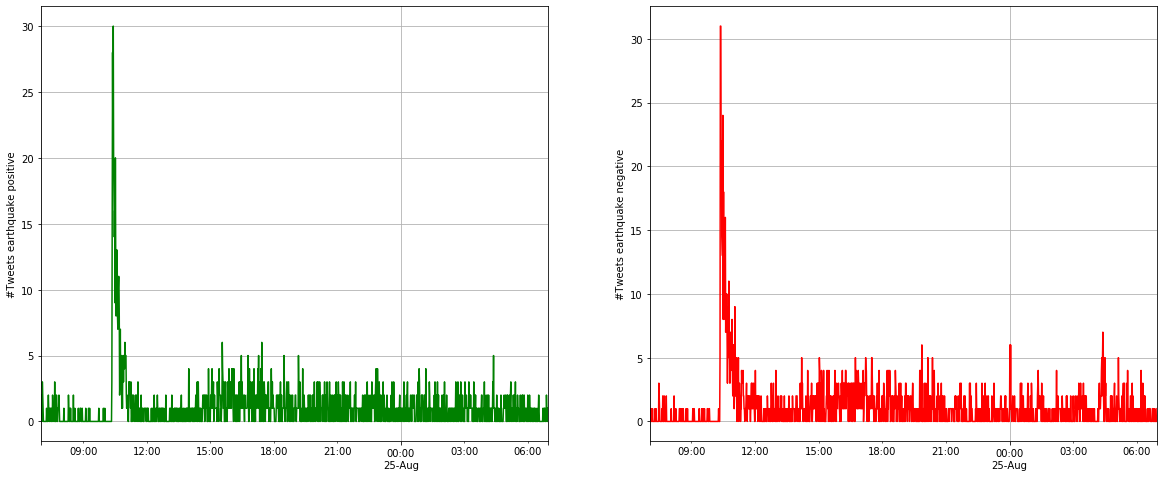

In [91]:
figure, axes = plt.subplots(1, 2,figsize=(20,8))
ax = df_sum_earth_pos.plot(ax=axes[0],color='green')
axes[0].grid()
axes[0].set_ylabel("#Tweets earthquake positive")

ax = df_sum_earth_neg.plot(ax=axes[1],color='red')
axes[1].grid()
axes[1].set_ylabel("#Tweets earthquake negative")

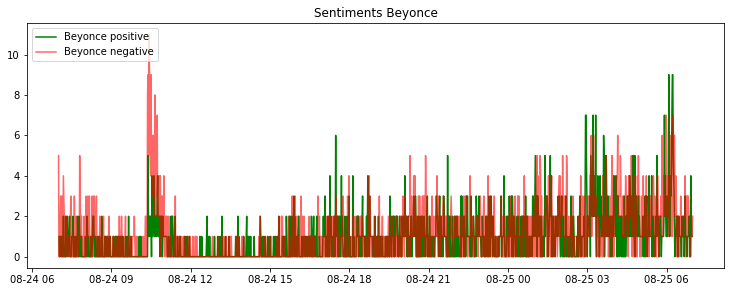

In [92]:
plt.figure(figsize=(12.5,4.5))
plt.plot(df_sum_bey_pos,label = 'Beyonce positive',color='green')
plt.plot(df_sum_bey_neg,label = 'Beyonce negative',color='red',alpha=0.6)
plt.title('Sentiments Beyonce')
plt.legend(loc='upper left')
plt.show()

Text(0, 0.5, '#Tweets Beyonce negative')

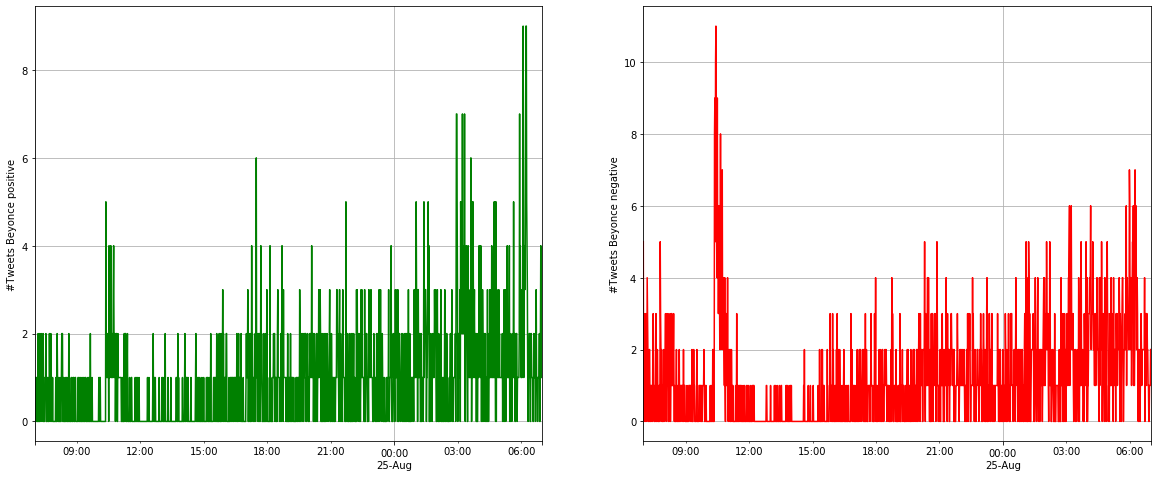

In [93]:
figure, axes = plt.subplots(1, 2,figsize=(20,8))
ax = df_sum_bey_pos.plot(ax=axes[0],color='green')
axes[0].grid()
axes[0].set_ylabel("#Tweets Beyonce positive")

ax = df_sum_bey_neg.plot(ax=axes[1],color='red')
axes[1].grid()
axes[1].set_ylabel("#Tweets Beyonce negative")